In [1]:
"""
@Hazırlayan:  Mustafa Serhat USLU     21/07/2020        ---> ARAÇ PLAKA TESPİTİ 

"""

#GENEL BÖLÜT AÇIKLAMALARI BÜYÜK HARFLERLE ÜZERLERİNDEKİ YORUMLARDA VERİLMİŞTİR.  
#SAĞ TARAFTA YER ALAN KÜÇÜK HARFLİ AÇIKLAMALAR SATIRLARA AİTTİR. 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))          #Görsellik için, kutucukları enine genişletiyoruz.

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)                ##Gereksiz uyarıların basılmasını engelle.
warnings.simplefilter(action='ignore', category=Warning)                 


from importlib.machinery import SourceFileLoader                              #WPOD-NET ağına ait utils modülünü çekiyoruz. 
utils = SourceFileLoader("utils", "C:/Users/Mustafa/Desktop/LicencePlateDetection/Plate_detect_and_recognize-master/utils.py").load_module()

import cv2                                                                    #Görsellerde ön işleme yapmak için kullanacağız. 
import numpy as np                                                            #Çok boyutlu array ve matrislerde işlem yapablmek için.                                                     
import matplotlib.pyplot as plt                                               ##Matplotlibi görselleri çizdirmek için kullanıyoruz. 
import matplotlib.gridspec as gridspec
from os.path import splitext, basename                                        #PC de path işlemlerini görmek için OS kütüphanesi kullanıyoruz
from keras.models import model_from_json                                      #Önceden eğitilmiş wpod-net modelini JSON formatında yüklemek için keras.models kullanıyoruz.  
import glob                                                                   #Dosya path'lerinde desen eşleyebilmek için glob kullanıyoruz.


Using TensorFlow backend.


In [2]:
#BU FONKSİYONLA GÖRSELLERDEN PLAKA TESPİTİ YAPAN MODELİN AĞIRLIKLARINI JSON DOSYASINDAN ÇEKİYORUZ. (model ismi-> WPOD-NET) 
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Plaka Tanımı Yapan Model WPOD-NET Başarıyla Sisteme Yüklenmiştir...")
        return model
    except Exception as e:
        print(e)

In [3]:
#WPOD-NET'İ BULUNDURAN DOSYAYI BELİRLİYORUZ VE MODELİ SİSTEME YÜKLÜYORUZ.
wpod_net_path = "C:/Users/Mustafa/Desktop/LicencePlateDetection/Plate_detect_and_recognize-master/wpod-net.json"
wpod_net = load_model(wpod_net_path)


Plaka Tanımı Yapan Model WPOD-NET Başarıyla Sisteme Yüklenmiştir...


In [4]:
#BU FONKSİYON preprocess_image FONKSİYONU İÇİNDE ÇAĞRILIR, PLAKA TESPİTİ YAPILAMAYAN BULANIK ARAÇ GÖRSELLERİNDE BAZI DURUMLARDA CİSİM KENAR TESPİTİNİ NİSPETEN KOLAYLAŞTIRIR.
def sharpen_image(image,gorsellestir=False):                                   # "Gorsellestir" opsiyonu aradaki farka bakmak için True yapılabilir. 
    image = cv2.imread(image)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])             ##Bu iki satır okunan görselin keskinleştirilmesini sağlar. 
    only_sharpen = cv2.filter2D(image, -1, sharpen_kernel)
    sharpened_image = cv2.GaussianBlur(only_sharpen, (5, 5), 0.0)              #Keskinleştirilen görsele Gaussian filtresi ile yumuşatılma yapılır.
    
    if (gorsellestir == True):
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.axis(False)
        plt.imshow(image)                                                      #Keskinleştirilmeden önceki görseli yazdır.                                       
        plt.subplot(1,2,2)
        plt.axis(False)
        plt.imshow(sharpened_image)                                            #Keskinleştirildikten sonraki görsel.
        
    return sharpened_image 

In [5]:
#BU FONKSİYONLA ÖRNEK GÖRSELLERİ OKU, MATPLOTLİB'TE ÇİZİM İÇİN NORMALLEŞTİR VE BİR SONRAKİ ADIMDA GÖRSELLERİ GÖSTEREBİLMEK AMAÇLI RESİZE
def preprocess_image(img,resize=False,sharpen=True):
    if (sharpen==True):
        img = sharpen_image(img)
    else:                                                                     #Eğer sharpen_image fonksiyonu kullanılmıyorsa cv.imread ile görseli bu fonksiyonda okumalıyız.
        img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                                #OpenCv resimleri BGR formatında okur fakat biz işlem yapabilmek için RGB'ye çeviricez.
    img = img / 255                                                           #Matplotlib ile işlem yapabilmek için görselleri 0-1 aralığına normalleştiriyoruz.
    if resize:                                                                #Görselleştirme amaçlı bir resize fonksiyonu ekliyoruz.
        img = cv2.resize(img, (224,224))
    return img


In [47]:
#TEST GÖRSELLERİNİN BULUNDUĞU DOSYADAN BÜTÜN HEPSİNİ ÇEKİYORUZ
image_paths = glob.glob(r"C:\Users\Mustafa\Desktop\LicencePlateDetection\ostim_plates\*.jpg")
print("Sağlanan Dosya Adresinde %i Adet Görsel Bulundu..."%(len(image_paths)))


Sağlanan Dosya Adresinde 35 Adet Görsel Bulundu...


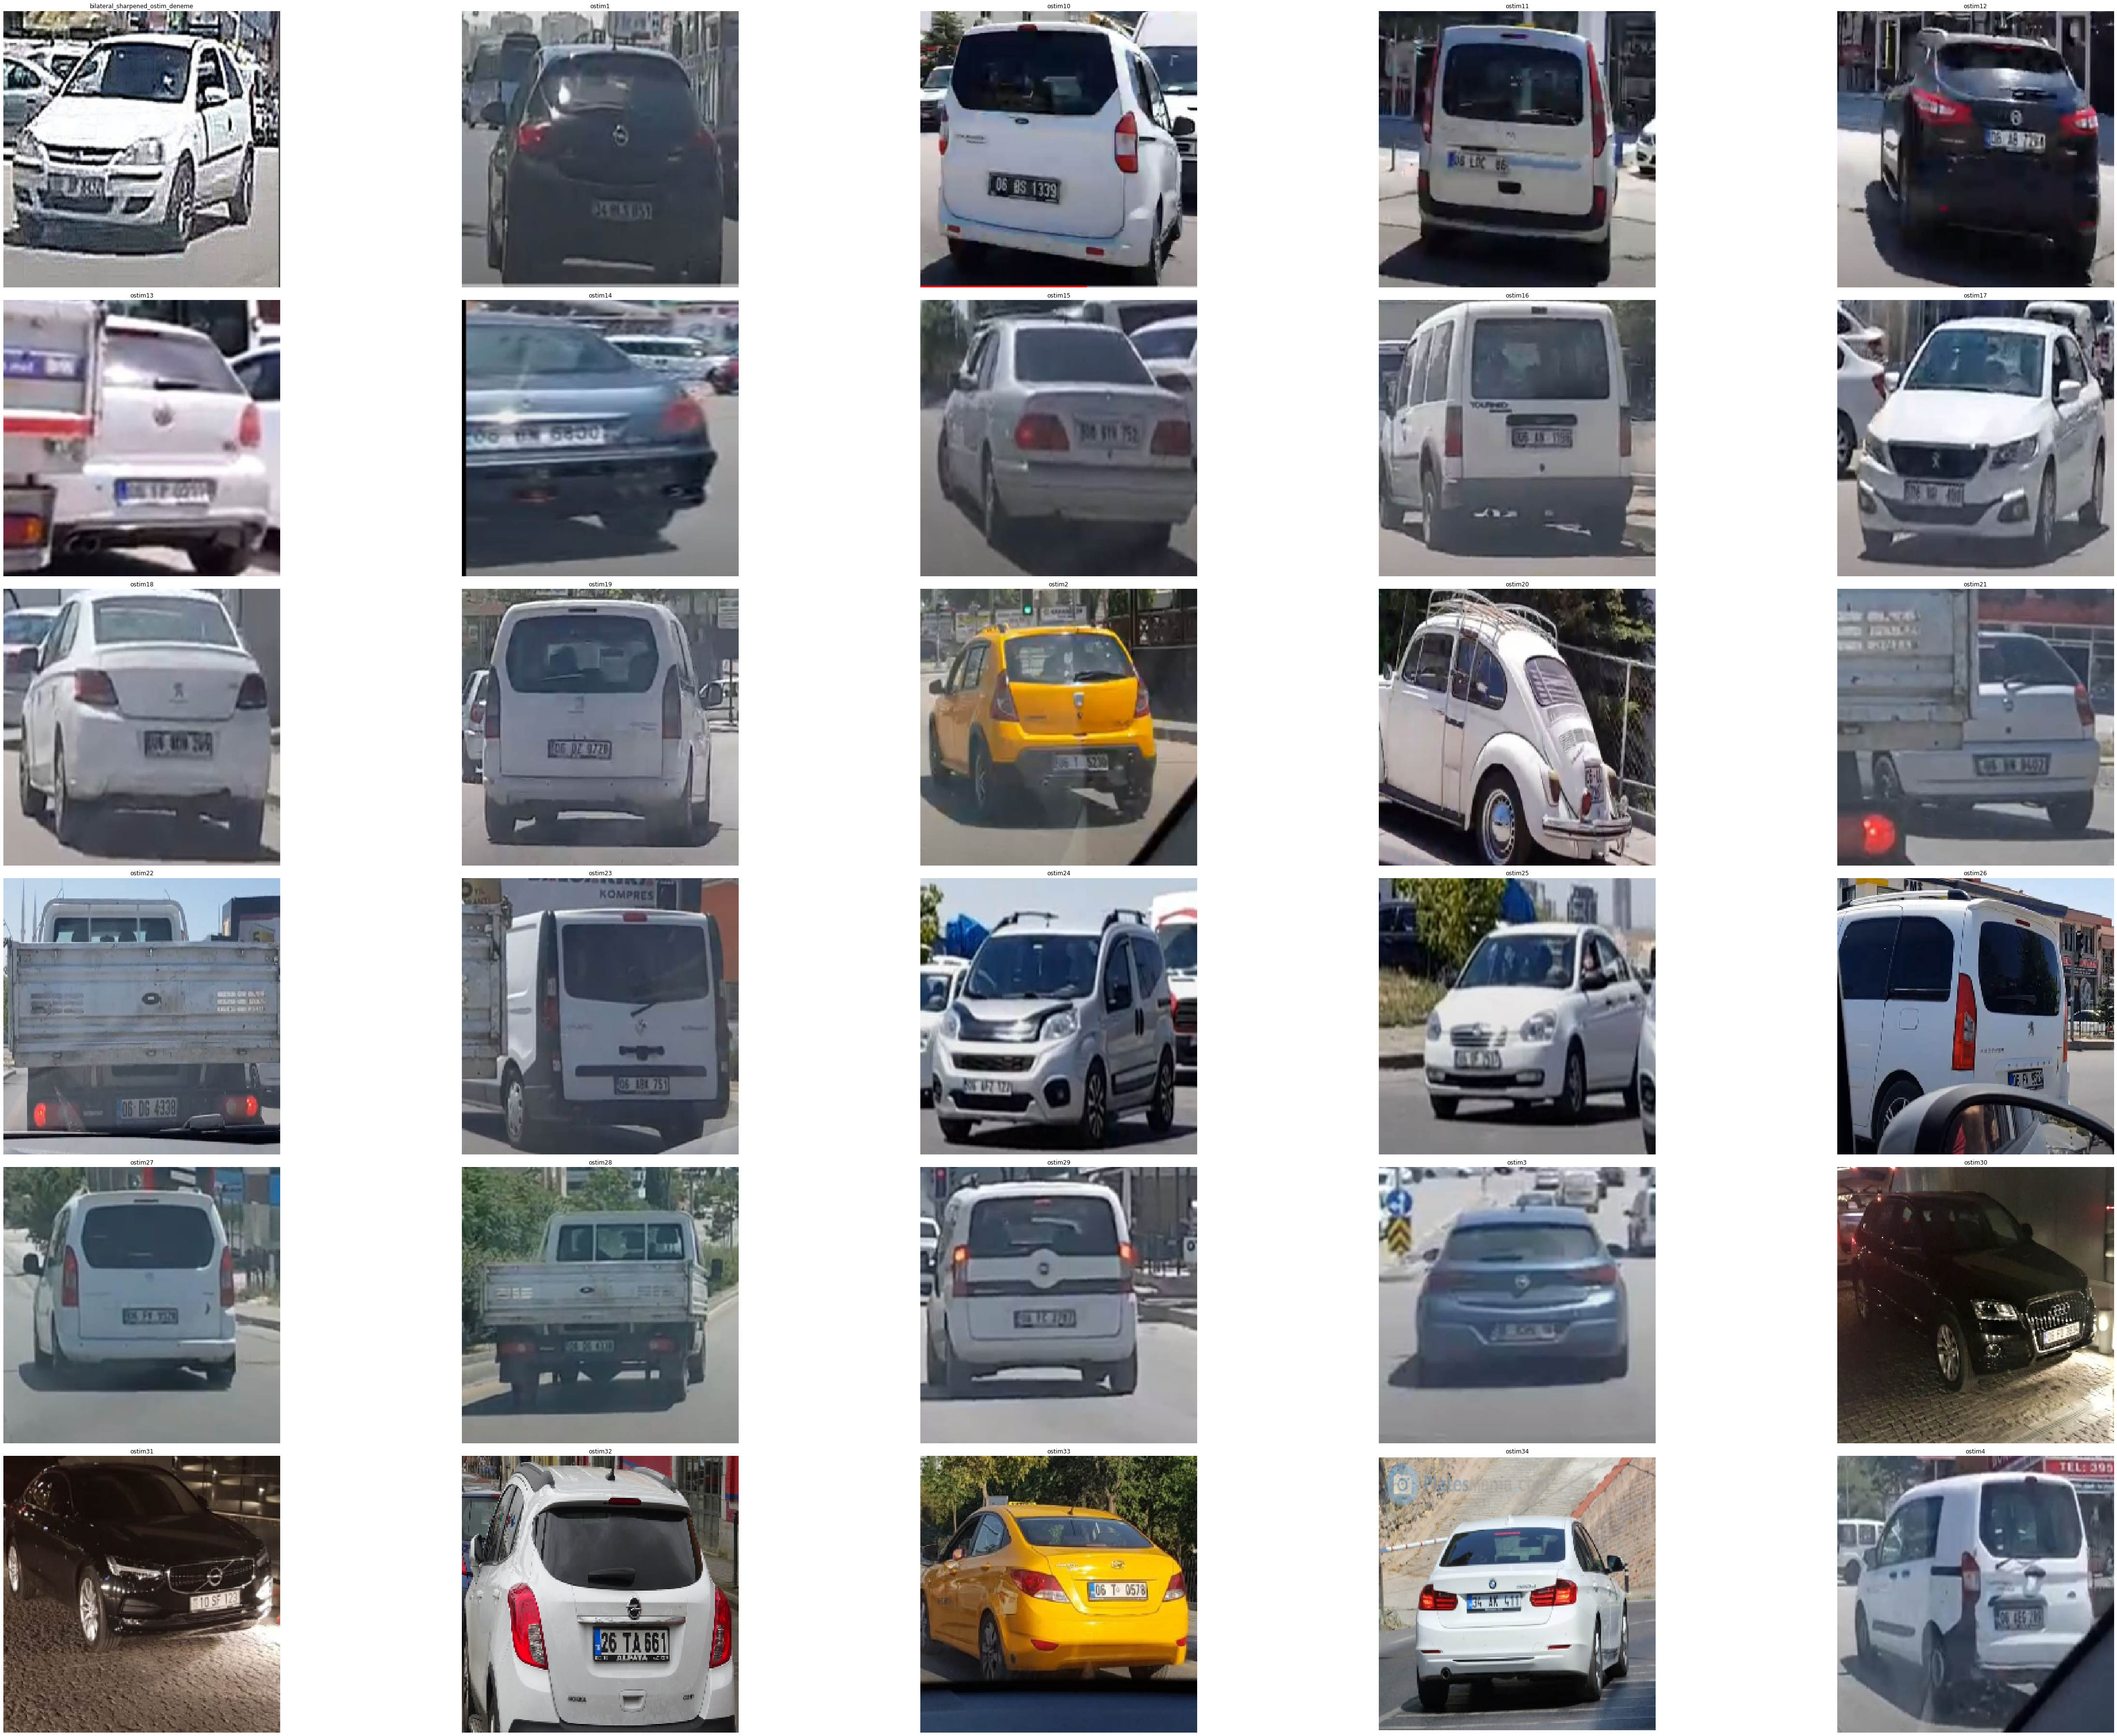

In [48]:
#TEST GÖRSELLERİMİZİ BİR ARADA BİR POSTER ÜZERİNDE ÇİZDİRİYORUZ. 
fig = plt.figure(figsize=(70,50))                                             #Test görsellerini çizdirmek için görsel boyutu belirliyoruz. 
cols = 5                                                                      ## 5'e-4'lük bir postere görseleri yerleştirmek için parametreler kuruyoruz.
rows = 6
fig_list = []

for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))                           #rows x cols kolonuna i+1 numaralı görseli yazdırıyoruz.
    title = splitext(basename(image_paths[i]))[0]                             #Görselin pc'de kayıtlı isminide alıyoruz çünkü üstüne yazdıracağız.
    fig_list[-1].set_title(title)                                             #En son eklenen görselin başlığını önceki satırda dosya isminden aldık şimdi bastırıyoruz. 
    img = preprocess_image(image_paths[i],True,False)                         #Postere eklenen görselin önceki tanımladığımız fonksiyon ile ön işlemesini yapıyoruz.
    plt.axis(False)                                                           #Görselleri bastığımız poster sınırlarını görünmez hale getiriyoruz.
    plt.imshow(img)                                                           #İşlenen test görselini postere ekliyoruz.

plt.tight_layout(True)                                                        #Posterde padding ayarı.
plt.show()                                                                    #Posteri yazdır.

In [50]:
#GET_PLATE FONKSIYONU GÖRSELLERDEN PLAKALARIN KOORDIANATLARI ÇEKER VE SADECE PLAKADAN OLUŞAN YENİ BİR GÖRSEL OLUŞTURUR, BİZ BU GÖRSEL ÜZERİNDE OKUMA İŞLEMİ YAPICAZ
#10. satırda yer alan lp_threshold limiti düşürülerek plaka tespiti zor olan görsellerde plaka tespiti kolaylaşır fakat hatalı tespitler artar.
def get_plate(image_path):
    Dmax = 608
    Dmin = 288
    vehicle = preprocess_image(image_path)                                    #Önceden kurduğumuz ön işleme fonksiyonuna plakası alınacak görseli sokuyoruz. 
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])            ###Bu üç satır plaka boyut kısıtlamaları içerir ki plaka olmayan görselleri böylece eleriz. 
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = utils.detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.2)  #Bu fonksiyon WPOD-NET ağının utils kütüphanesinden gelir ve belirlenen filtrele uygun olarak görsellerden plaka çıkartır.(extracting the LicencePlates) 
    return LpImg, cor                                                         #Fonksiyon çıktısı olarak plaka görseli ve koordinatları elde ediyoruz.


In [51]:
#ARAÇ GÖRSELLERİNDEKİ PLAKA ETRAFINI ÇİZME AMAÇLI BİR FONKSİYON, choose_photo FONKSİYONU İÇİNDE ÇAĞIRILIR. 
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image


In [52]:
#BU FONKSİYON İLE VERİ SETİNDEN GÖRSEL SEÇ VE PLAKANIN RESIMDEKİ KOORDİNATLARINI AL VE SEÇİLEN TEST FOTORAFINI VE ELDE EDİLEN PLAKA FOTORAFINI GÖRSELLEŞTİR.
def choose_photo(path_number):
    test_image = image_paths[path_number]                                      #Test için fotoğraf seçiyoruz.
    LpImg,cor = get_plate(test_image)                                          #Fotoğraftan plaka görseli ve koordinatlarını çek. 
    print("İÇİNDE %i ADET PLAKA TESPİT EDİLEN GÖRSELİN İSMİ: "%len(LpImg),splitext(basename(test_image))[0])   
    print("\nTESPİT EDİLEN PLAKANIN KOORDİNATLARI: \n", cor)                   #Test görselindeki plaka koordinatlarnı yazdır. 
    print("\n")
    
    plt.figure(figsize=(8,8))
    plt.axis(False)
    plt.imshow(draw_box(test_image,cor))                                       # draw_box fonksiyonu ile plakanın etrafını çiziyoruz.
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.axis(False)
    plt.imshow(preprocess_image(test_image))                                   #Plakasının alındığı görseli yazdırıyoruz. 
    plt.subplot(1,2,2)
    plt.axis(False)
    plt.imshow(LpImg[0])                                                       #Elde edilen plaka görselini yazdırıyoruz.
    
    return test_image, LpImg, cor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


İÇİNDE 1 ADET PLAKA TESPİT EDİLEN GÖRSELİN İSMİ:  ostim32

TESPİT EDİLEN PLAKANIN KOORDİNATLARI: 
 [array([[430.90434057, 679.69326319, 679.77616754, 430.98724491],
       [323.28477308, 322.79438413, 386.59552208, 387.08591103],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]




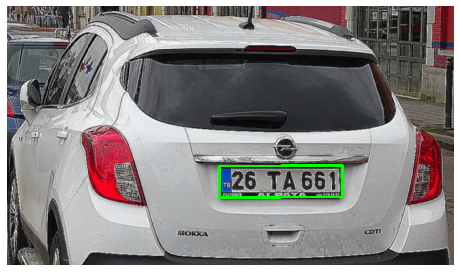

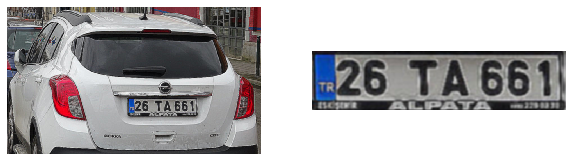

In [61]:
#TEST EDiLMEK İSTENEN GÖRSELİ BURADAN GİREBİLİRSİNİZ.                         #PLAKA BULUNAMAZSA LİST İNDEX OUT OF RANGE HATASI DÖNER.
test_image, LpImg, cor = choose_photo(26)                                      #Fonksiyonu başlatıyoruz çünkü "test_image, LpImg, cor" ilerleyen satırlarda değişkenlerimize ihtiyaç var.

Üzerinde OpenCV ile MOBİLE-NET için kenar hatları (Contours) analizi yapılacak olan görsel:


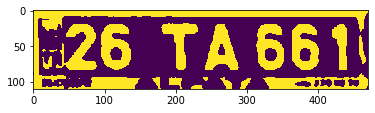

In [62]:
#ŞİMDİ, GÖRSELLERDEN PLAKALARI ÇEKEBİLDİĞİMİZ İÇİN BU PLAKALARIN OKUNABİLİRLİĞİNİ GÖRÜNTÜ ÖN-İŞLEME TEKNİKLERİYLE ARTTIRMALIYIZ:
#   - Blur ekleyerek görseldeki gürültü ve gereksiz bilgiyi minimize edeceğiz, fakat fazla eklenirse bilgi kaybı olur. 
#   - Harfleri arka plandan daha başarılı ayırabilmemiz amaçlı Tresholding uygulayacağız. (inverse binary tresholding)
#   - Plakalarda kenarların daha belirgin olmasını sağlamak için dilation ( figür kenarlarını genişletme) işlemi yapıyoruz.
#   - Plaka okunabilirliğinde renk gereksiz işlem gücü harcadığından grayscale'e çevireceğiz. 
#   - WPOD-NET kullanarak çektiğimiz plaka görselleri 0-1 formatında Matplotlib için minimalize edilmişti, bunları tekrar 8 bit 0-255 formatına getireceğiz.  

#YUKARIDA BAHSEDİLEN İŞLEMLERİ AŞAĞIDAKİ FONKSİYONLA GERÇEKLEŞTİRİYORUZ.
if (len(LpImg)):                                                               #PlakaGörseliVarsa ilerle
    
 
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))                 #8-bit'e çeviri yapıyoruz. 
    
   
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)                       #Grayscale'e çeviri
    blur = cv2.GaussianBlur(gray,(5,5),2)                                      #Blur ekle (Yeteri kadar bilgi edinemiyorsa kernel size azaltılmalıdır.
    
    
    binary = cv2.threshold(blur,120, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]    #Threshold ile binary bir görsel elde ediyoruz.
                       
     
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))                ##Dilation ile kenar belirginliğini arttır.
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    
    print("Üzerinde OpenCV ile MOBİLE-NET için kenar hatları (Contours) analizi yapılacak olan görsel:")
    plt.imshow(thre_mor)

In [63]:

#PLAKA GÖRSELLERİNDEKİ KARAKTERLERİN HATLARINI BELİRLİYORUZ VE İÇİNİ DOLDURUYORUZ.
cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #binary--> ön işlemesi yapılmış plaka görselidir RETR_EXTERNAL--> Figürelerin sadece dış hatlarını çizmeye yarar.  CHAIN_APPROX_SIMPLE-->Outline'ları çizilen figürlerin içini doldurur.

test_roi = plate_image.copy()                                                  #Görselleştirme amaçlı plaka görselinin bir kopyasını alıyoruz .

crop_characters = []                                                           #Elde edilen karakter figürlerini saklayacak bir liste.

digit_w, digit_h = 30, 60                                                      #Plakadan elde edilen karakter görsellerinin boyut standartlarını belirliyoruz. 


MOBİLE-NET tahmini için plakada bulunan Figür sayısı: 7 ...


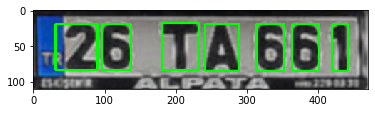

In [64]:
#BU FONKSİYON PLAKA GÖRSELİNDEN ELDE EDİLEN KARAKTERLERİN ETRAFININ ÇİZİLMESİ VE SOLDAN SAĞA DOĞRU SIRAYA DİZİLMESİNİ SAĞLAR.  
def sort_contours(cnts,reverse = False):                                      
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts


for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5:                                                          #plakanın eni genişliğinden fazla olduğundan böyle bir kısıtlama koyuyoruz. 
        if h/plate_image.shape[0]>=0.4:                                        #Harflerin boyunun plakanın boyundan yarınsından fazla olduğunu varsayıyoruz ve buna göre kısıtlıyoruz.
            
            detected_figures_on_plate = cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)     #Rakam yada numaranın etrafını dikdörtgen ile çiziyoruz.
            plt.imshow(detected_figures_on_plate)
            
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)
            
print("MOBİLE-NET tahmini için plakada bulunan Figür sayısı: {} ...".format(len(crop_characters)))

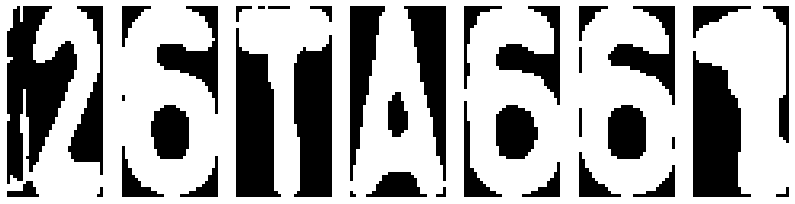

In [65]:
#ELDE EDİLEN, MOBİLE-NET AĞINDA TAHMİNLERİ YAPILACAK OLAN FİGÜRLERİN SİYAH BEYAZ ÇİZİMİNİ YAPIYORUZ.
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
    
   

In [66]:
#FİGÜR TAHMİNİ YAPAN MODEL MİMARİSİNİ (MOBİLE-NET), AĞIRLIKLARINI VE ETİKETLERİNİ YÜKLÜYORUZ.   
json_file = open(r"C:\Users\Mustafa\Desktop\LicencePlateDetection\Plate_detect_and_recognize-master\MobileNets_character_recognition.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(r"C:\Users\Mustafa\Desktop\LicencePlateDetection\Plate_detect_and_recognize-master\License_character_recognition_weight.h5")
print("[INFO] MODEL BAŞARIYLA YÜKLENMİŞTİR...")

from sklearn import preprocessing
labels = preprocessing.LabelEncoder()
labels.classes_ = np.load(r"C:\Users\Mustafa\Desktop\LicencePlateDetection\Plate_detect_and_recognize-master\license_character_classes.npy")
print("[INFO] ETİKETLER BAŞARIYLA YÜKLENMİŞTİR...") 

[INFO] MODEL BAŞARIYLA YÜKLENMİŞTİR...
[INFO] ETİKETLER BAŞARIYLA YÜKLENMİŞTİR...


In [67]:
#FİGÜR TAHMİNİ YAPAN MODEL İÇİN ÖNİŞLEME VE TAHMİN YÜRÜTME YAPIYORUZ.
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))                                          ##Rakam ve Sayı tahmini yapan model 80x80x3 boyutunda görsel aldığından dolayı çeviriyoruz.
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])   #Tahmin üretiyoruz.
    return prediction


MOBILE-NET KARAKTER TAHMİN SONUCU:  26TA661


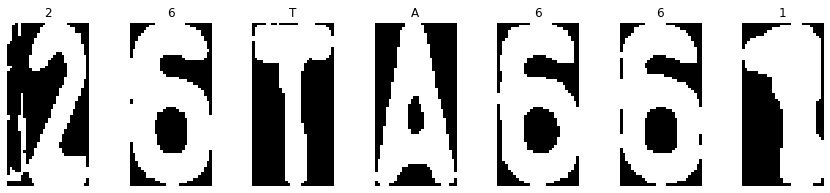

In [71]:
#_______________________________________________________MOBİLE-NET TAHMİNİ
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print("MOBILE-NET KARAKTER TAHMİN SONUCU: ", final_string)
#plt.savefig('final_result.png', dpi=300)  


TESSARACT KARAKTER TAHMİN SONUCU: 26 TA 661

TESSERACT'A GİRDİ OLARAK VERİLEN PLAKA GÖRSELİ:


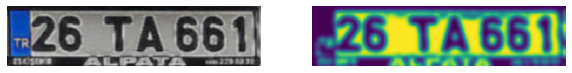

In [72]:
#___________________________________________TESSARACT TAHMİNİ
import pytesseract


gray_plate = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(gray_plate, 120, 255, cv2.THRESH_BINARY)

Gaussian_plate = cv2.GaussianBlur(blackAndWhiteImage, (25, 25), 4 )


text = pytesseract.image_to_string(Gaussian_plate)

print("TESSARACT KARAKTER TAHMİN SONUCU:", text)
print("\nTESSERACT'A GİRDİ OLARAK VERİLEN PLAKA GÖRSELİ:")


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(plate_image)                                  
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(Gaussian_plate) 